In [1]:
import inspect
from typing import List, Optional, Union
import numpy as np
import torch
import cv2
import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageOps
from torchvision.utils import save_image
from diffusers import StableDiffusionInpaintPipeline
import matplotlib.pyplot as plt
%matplotlib inline
from mask_functions import *
#!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

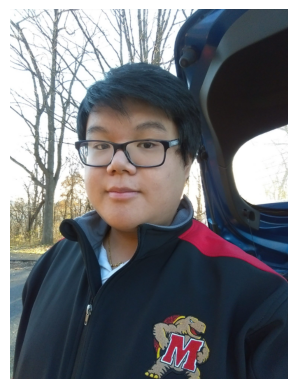

In [2]:
# Load image
im_path = "./ims/ch.png"
image = Image.open(im_path)
#image = image.resize((512,512))
plt.imshow(image)
plt.axis('off');

In [3]:
# Init face detector/predictor
landmark_path = "shape_predictor_68_face_landmarks.dat"
detector, predictor = get_face_predictor_detector(landmark_path)

In [4]:
# Convert image to grayscale numpy
image_gray = np.array(ImageOps.grayscale(image))

# Get mustache mask and resize
mask, debug_image = get_image_mask(image_gray, detector, predictor)
mask = cv2.resize(mask,(512,512))
debug_image = cv2.resize(debug_image,(512,512))
image = cv2.resize(np.array(image),(512,512))

Found 1 faces
Time to get image mask:  131.25 ms


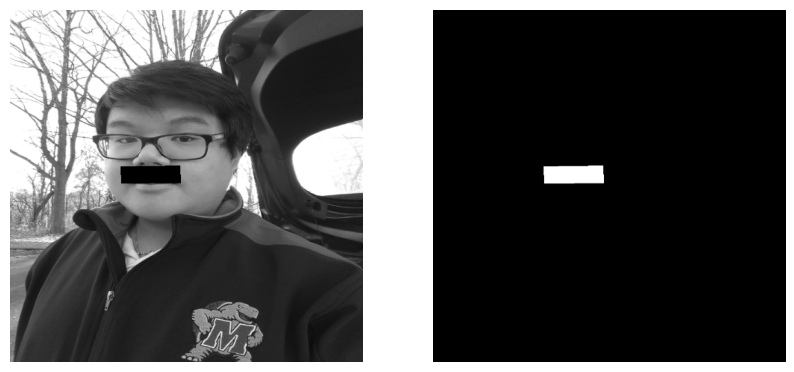

In [5]:
# Look at debug image and mask
fig1 = plt.figure(figsize=(10,5));
ax1,ax2 = fig1.subplots(1,2);
ax1.imshow(debug_image,cmap='gray');
ax2.imshow(mask,cmap='gray'); 
ax1.axis('off');ax2.axis('off');

In [10]:
# Define the inpainting pipeline
device = "cuda"
model_path = "stabilityai/stable-diffusion-2-inpainting"
#"runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

text_encoder\model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [21]:
# Inpainting settings
prompt   = "a high quality hyper-realistic photograph of a man with a mustache, thick mustache, dark mustache, facial hair"
n_prompt = "cartoon, blurry, ugly, bad anatomy, disfigured"

cfg = 7
denoise = .8
steps = 20
num_samples = 1
generator = torch.Generator(device=device).manual_seed(np.random.randint(1e5)) # change the seed to get different results

  0%|          | 0/20 [00:00<?, ?it/s]

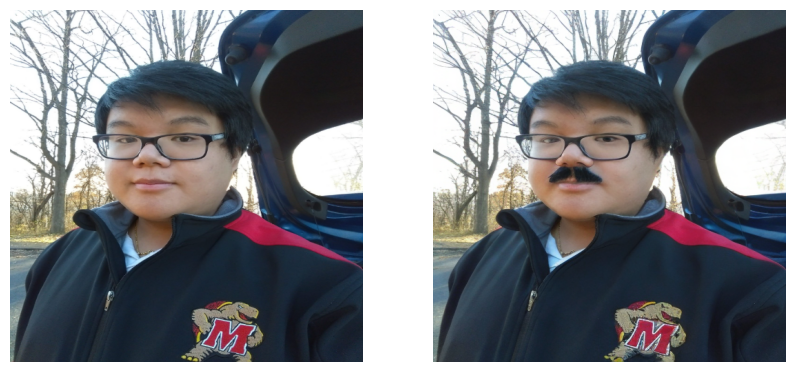

In [22]:
# Run inpainting
images = pipe(
    height=512,
    width=512,
    prompt=prompt,
    negative_prompt=n_prompt,
    num_inference_steps=steps,
    image=Image.fromarray(image),
    mask_image=Image.fromarray(mask),
    guidance_scale=cfg,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

# Show result
images.insert(0, image)
fig1 = plt.figure(figsize=(10,5))
ax1,ax2=fig1.subplots(1,2)
ax1.imshow(images[0])
ax2.imshow(images[1])
ax1.axis('off'); ax2.axis('off');
